In [19]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt 
import time

config_file = 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
# url: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
checkpoint_file = 'laboro_tomato_big_48ep.pth'

load checkpoint from local path: laboro_tomato_big_48ep.pth


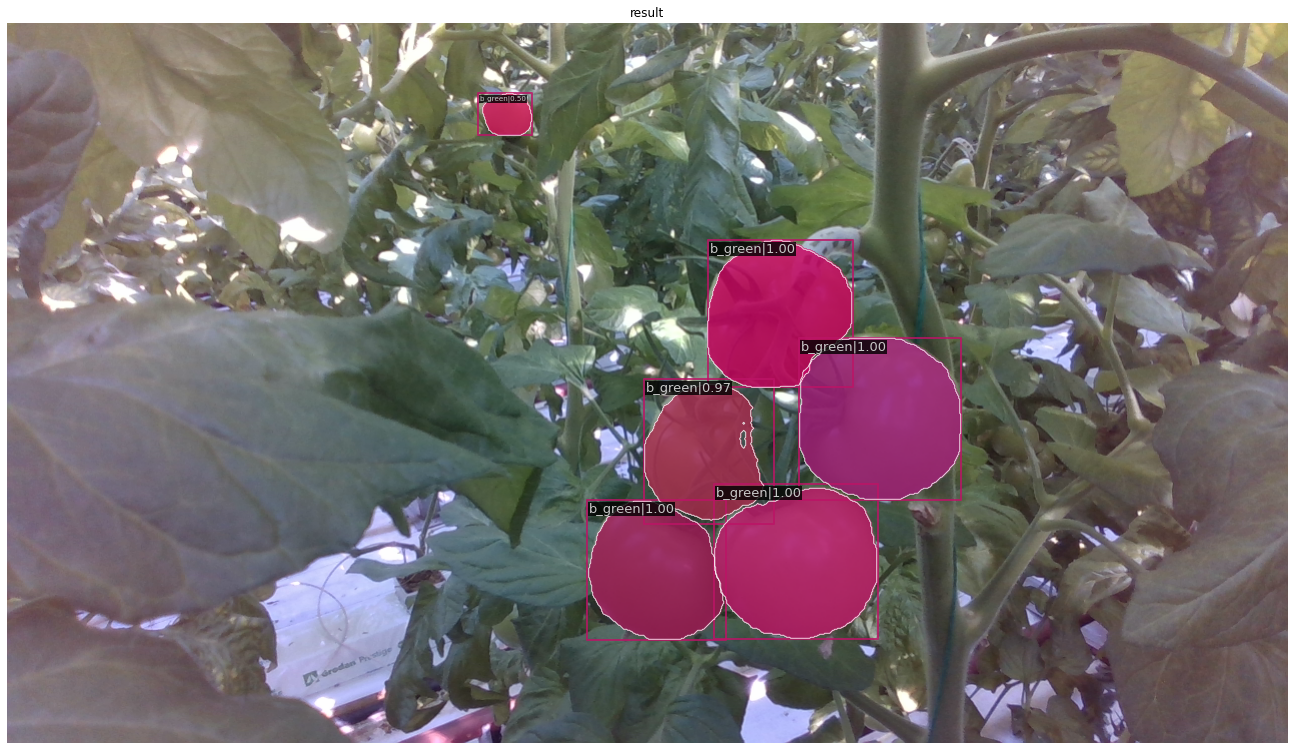

In [20]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/1c085f5f04d4494087d1f7ca80da4f0f color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/1c085f5f04d4494087d1f7ca80da4f0f depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segm_result = [x for x in segm_result if x != []]
segment = np.vstack(segm_result)

In [21]:
print(bboxes)

[[7.06803284e+02 4.61457275e+02 8.70339722e+02 6.16947021e+02
  9.99888182e-01]
 [5.79398193e+02 4.77999939e+02 7.18508728e+02 6.17445190e+02
  9.99834418e-01]
 [7.91258667e+02 3.15306763e+02 9.53615540e+02 4.77596558e+02
  9.99474466e-01]
 [7.00065125e+02 2.17248962e+02 8.45258606e+02 3.64695343e+02
  9.99459207e-01]
 [6.36690247e+02 3.56154327e+02 7.66770447e+02 5.01865326e+02
  9.74931717e-01]
 [4.70217804e+02 7.02258759e+01 5.24615784e+02 1.12944565e+02
  4.98371154e-01]]


In [22]:
import pyrealsense2 as rs
color_intrin = rs.pyrealsense2.intrinsics() #create a color intrinsics property
color_intrin.width = 1280
color_intrin.height = 720
color_intrin.ppx = 646.9525146484375
color_intrin.ppy = 375.3297119140625
color_intrin.fx = 911.9494018554688
color_intrin.fy = 912.0560302734375
color_intrin.model = rs.pyrealsense2.distortion.inverse_brown_conrady
color_intrin.coeffs = [0.0, 0.0, 0.0, 0.0, 0.0]

In [23]:
import math
height = []
width = []

start = time.clock()

for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    
    topDepth = depthData[yMin][xMid]
    botDepth = depthData[yMax][xMid]
    leftDepth = depthData[yMid][xMin]
    rightDepth = depthData[yMid][xMax]
    
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, topDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, botDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, leftDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, rightDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)

end = time.clock()
print(end - start)
print(height)
print(width)
    

0.0003990000000158034
[5.544953937984328, 10.450269931033805, 5.740084480179216, 7.1947544887731905, 5.432346045872829, 4.250904166586573]
[5.699725786003991, 5.564912428214055, 70.74100293037196, 5.630177462450411, 5.330541917202536, 24.03926544947209]


C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [24]:
from scipy.ndimage import convolve
from numpy import median

height = []
width = []
count = 0
start = time.clock()
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix
    fil = [[-1,-1,-1],
           [-1, 8,-1],
           [-1,-1,-1]]

    output = convolve(mask,fil, mode='constant')
    edgeDepth =[]
    for y in range(len(output)):
            for x in range(len(output[y])):
                    if output[y][x] > 0:
                        edgeDepth.append(depthData[y][x])
    centerDepth = median(edgeDepth)

    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, centerDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, centerDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, centerDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, centerDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    count = count + 1
    
end = time.clock()
print(end - start)

print(height)
print(width)

C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


5.9800000030918454e-05
4.500000000007276e-05
4.789999991317018e-05
4.5300000010684016e-05
4.5800000066265056e-05
4.720000003999303e-05
[5.438262224197388, 5.126878619194031, 5.6838614866137505, 5.496044224128127, 5.230490816757083, 3.9971202611923218]
[5.754705332219601, 5.09085301309824, 5.684526637196541, 5.4219018667936325, 4.689953709021211, 5.139759182929993]


In [25]:
from scipy.ndimage import convolve
from numpy import median

height = []
width = []
count = 0
start = time.clock()
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix
    # Find contours
    cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)

    # Obtain outer coordinates
    left = tuple(c[c[:, :, 0].argmin()][0])
    right = tuple(c[c[:, :, 0].argmax()][0])
    top = tuple(c[c[:, :, 1].argmin()][0])
    bottom = tuple(c[c[:, :, 1].argmax()][0])

    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, centerDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, centerDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, centerDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, centerDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    count = count + 1
    
end = time.clock()
print(end - start)

print(height)
print(width)

0.006373700000040117
[44.400035667018216, 36.93278126279323, 38.09897492854781, 27.307319159245747, 30.39627575156385, 4.001650684497063]
[15.7551360915712, 13.27411542347333, 15.441853236651898, 13.707344828469639, 12.011108520982917, 4.850438972783596]


C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
C:\Users\skwe9\miniconda3\envs\open-mmlab\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


load checkpoint from local path: laboro_tomato_big_48ep.pth


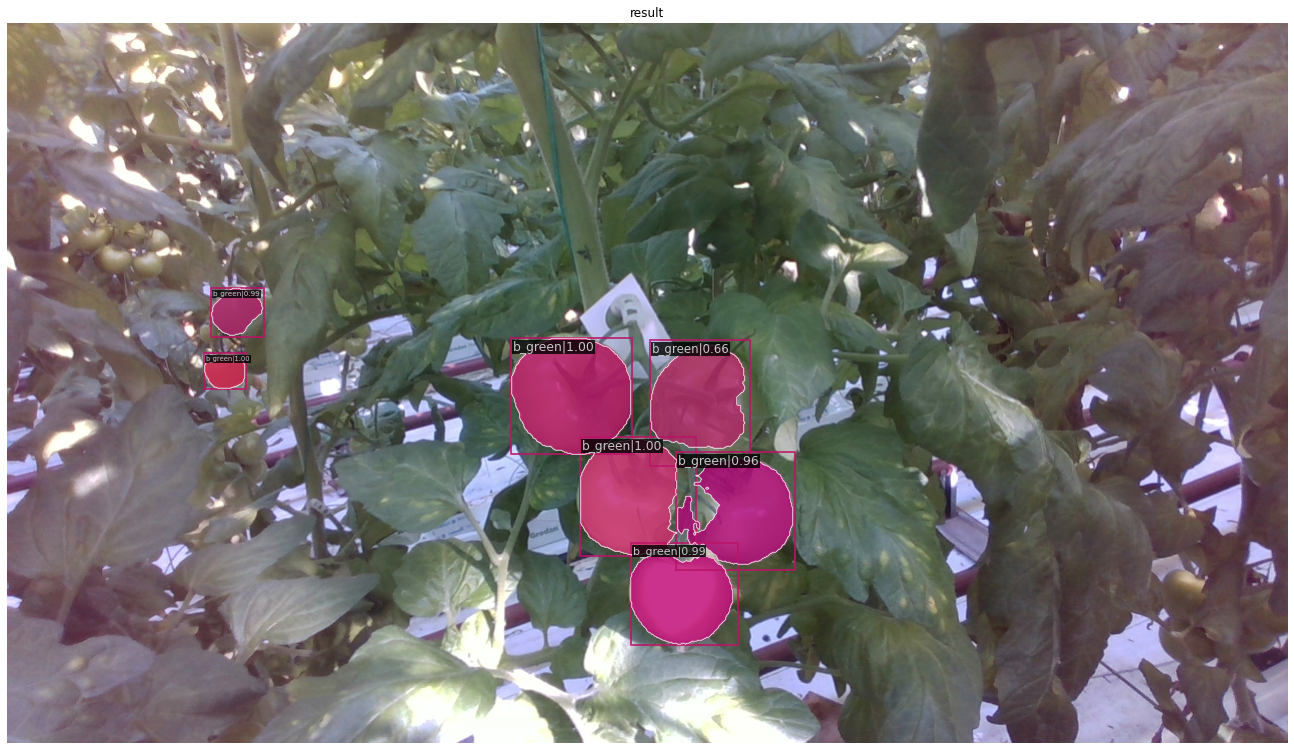

In [7]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/83a1d79d46cf4f8a923bfbedc34f8a92 color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/83a1d79d46cf4f8a923bfbedc34f8a92 depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segment = np.vstack(segm_result[2:])

In [8]:
print(bboxes)

[[5.0350278e+02 3.1502142e+02 6.2402332e+02 4.3199548e+02 9.9921513e-01]
 [5.7268402e+02 4.1488785e+02 6.8803180e+02 5.3327930e+02 9.9881941e-01]
 [1.9687543e+02 3.3016010e+02 2.3820580e+02 3.6612692e+02 9.9863738e-01]
 [6.2328027e+02 5.2021283e+02 7.3090759e+02 6.2207562e+02 9.9460196e-01]
 [2.0324261e+02 2.6524307e+02 2.5657568e+02 3.1426044e+02 9.9226111e-01]
 [6.6855292e+02 4.2945633e+02 7.8736389e+02 5.4726385e+02 9.6050763e-01]
 [6.4272137e+02 3.1706396e+02 7.4242560e+02 4.4326782e+02 6.5797764e-01]]


In [9]:
import math
height = []
width = []
for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    
    topDepth = depthData[yMin][xMid]
    botDepth = depthData[yMax][xMid]
    leftDepth = depthData[yMid][xMin]
    rightDepth = depthData[yMid][xMax]
    
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, topDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, botDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, leftDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, rightDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    
print(height)
print(width)
    

[5.986389189645258, 5.461462104920361, 4.174114645110078, 5.0334088726596855, 9.774678320841458, 6.110739544253317, 7.236952572487343]
[6.216012771139191, 6.008997513592762, 8.920503937348837, 28.78456391112104, 24.028747373672203, 7.326831431830644, 4.760719932236215]


In [10]:
height = []
width = []
count = 0
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix
    fil = [[-1,-1,-1],
           [-1, 8,-1],
           [-1,-1,-1]]

    output = convolve(mask,fil, mode='constant')
    edgeDepth =[]
    for y in range(len(output)):
            for x in range(len(output[y])):
                    if output[y][x] > 0:
                        edgeDepth.append(depthData[y][x])
    centerDepth = median(edgeDepth)
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, centerDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, centerDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, centerDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, centerDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    count = count + 1
    
print(height)
print(width)

[5.532555095851421, 5.558211542665958, 3.840553667396307, 4.786548018455505, 5.066245049238205, 5.524441413581371, 5.926609598100185]
[5.7717024348676205, 5.418721958994865, 4.481169581413269, 5.021770112216473, 5.480456352233887, 5.571909993886948, 4.704208602197468]


In [11]:
[[5.0350278e+02 3.1502142e+02 6.2402332e+02 4.3199548e+02 9.9921513e-01]
 [5.7268402e+02 4.1488785e+02 6.8803180e+02 5.3327930e+02 9.9881941e-01]
     [1.9687543e+02 3.3016010e+02 2.3820580e+02 3.6612692e+02 9.9863738e-01]
 [6.2328027e+02 5.2021283e+02 7.3090759e+02 6.2207562e+02 9.9460196e-01]
     [2.0324261e+02 2.6524307e+02 2.5657568e+02 3.1426044e+02 9.9226111e-01]
 [6.6855292e+02 4.2945633e+02 7.8736389e+02 5.4726385e+02 9.6050763e-01]
 [6.4272137e+02 3.1706396e+02 7.4242560e+02 4.4326782e+02 6.5797764e-01]]

SyntaxError: invalid syntax (388252746.py, line 1)

load checkpoint from local path: laboro_tomato_big_48ep.pth


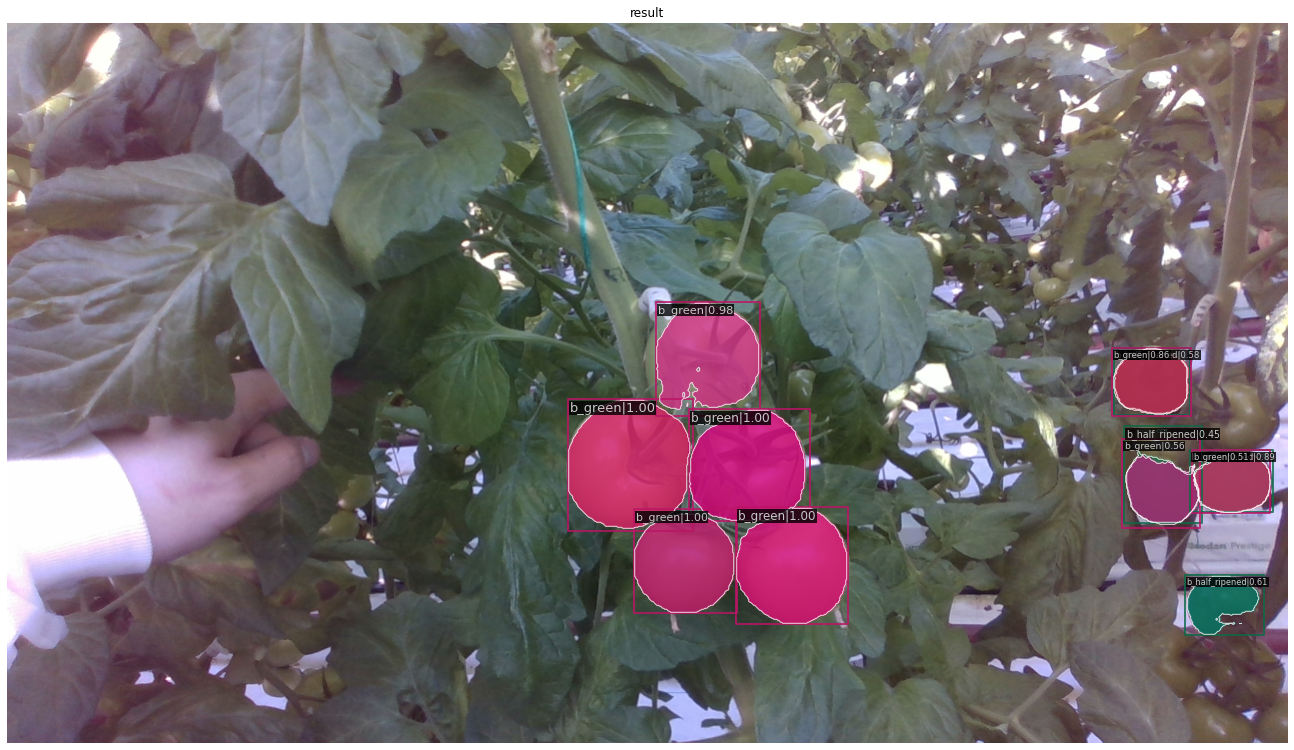

In [16]:
# build the model from a config file and a checkpoint file
img = mmcv.imread('image/374a7430eca74a89b741a537b8f30e15 color.png')
model = init_detector(config_file, checkpoint_file, device='cpu')
depthData = np.load('image/374a7430eca74a89b741a537b8f30e15 depthData.npy')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

bbox_result, segm_result = result

labels = [
    np.full(bbox.shape[0], i, dtype=np.int32)\
    for i, bbox in enumerate(bbox_result)
]
labels = np.concatenate(labels)
bboxes = np.vstack(bbox_result)
segment = np.vstack(segm_result[1:])

In [17]:
print(bboxes)

[[1.1825219e+03 4.2786813e+02 1.2653131e+03 4.8959836e+02 8.8863182e-01]
 [1.1772303e+03 5.5235748e+02 1.2560333e+03 6.1244623e+02 6.1234611e-01]
 [1.1068231e+03 3.2503918e+02 1.1828591e+03 3.9298172e+02 5.8162987e-01]
 [1.1161666e+03 4.0325928e+02 1.1944414e+03 5.0036310e+02 4.5326200e-01]
 [6.2651611e+02 4.8683273e+02 7.2960620e+02 5.9029260e+02 9.9974185e-01]
 [6.8135205e+02 3.8670477e+02 8.0217725e+02 4.9839563e+02 9.9956530e-01]
 [5.6083875e+02 3.7692221e+02 6.8514117e+02 5.0893994e+02 9.9888033e-01]
 [7.2883270e+02 4.8466263e+02 8.4051941e+02 6.0105103e+02 9.9800903e-01]
 [6.4872803e+02 2.7959613e+02 7.5250592e+02 3.9355032e+02 9.8176277e-01]
 [1.1049175e+03 3.2548462e+02 1.1839459e+03 3.9310040e+02 8.5678506e-01]
 [1.1146934e+03 4.1659793e+02 1.1929962e+03 5.0559488e+02 5.5531102e-01]
 [1.1842845e+03 4.2778491e+02 1.2625845e+03 4.9018741e+02 5.0531304e-01]
 [1.1774349e+03 5.5102118e+02 1.2559435e+03 6.1438715e+02 6.7941427e-02]]


In [18]:
import math
height = []
width = []
for bbox in bboxes:
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    
    topDepth = depthData[yMin][xMid]
    botDepth = depthData[yMax][xMid]
    leftDepth = depthData[yMid][xMin]
    rightDepth = depthData[yMid][xMax]
    
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, topDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, botDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, leftDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, rightDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    
print(height)
print(width)

[5.897131816802725, 5.8913755333006534, 12.824815833102402, 9.338999035658716, 4.89970001200781, 5.194958256413399, 6.188496692810524, 5.355465161101665, 5.850452858093371, 12.777429236574536, 8.518101752531534, 6.0270140979242575, 6.1706159378849215]
[6.297288708374987, 33.28989742988321, 23.821310797325264, 6.339877192057323, 4.640848142544826, 34.39494696865709, 5.899369682053805, 5.0821156723281575, 5.4575450846073, 24.29645446151373, 6.3738913876963235, 5.910320024884394, 33.34610755026628]


In [19]:
height = []
width = []
count = 0
for bbox in bboxes:
    mask = np.asarray(segment[count], dtype="uint8") #binary matrix
    fil = [[-1,-1,-1],
           [-1, 8,-1],
           [-1,-1,-1]]

    output = convolve(mask,fil, mode='constant')
    edgeDepth =[]
    for y in range(len(output)):
            for x in range(len(output[y])):
                    if output[y][x] > 0:
                        edgeDepth.append(depthData[y][x])
    centerDepth = median(edgeDepth)
    xMin = int(bbox[0])
    xMax = int(bbox[2])
    yMin = int(bbox[1])
    yMax = int(bbox[3])
    xMid = int((xMin + xMax)/2)
    yMid = int((yMin + yMax)/2)
    
    top = [xMid, yMin]
    bot = [xMid, yMax]
    left = [xMin, yMid]
    right = [xMax, yMid]
    topC = rs.rs2_deproject_pixel_to_point(color_intrin, top, centerDepth)
    botC = rs.rs2_deproject_pixel_to_point(color_intrin, bot, centerDepth)
    leftC = rs.rs2_deproject_pixel_to_point(color_intrin, left, centerDepth)
    rightC = rs.rs2_deproject_pixel_to_point(color_intrin, right, centerDepth)
    
    new_height = math.sqrt(math.pow(topC[0] - botC[0], 2) + math.pow(topC[1] - botC[1],2) + math.pow(topC[2] - botC[2], 2))*100
    new_width = math.sqrt(math.pow(leftC[0] - rightC[0], 2) + math.pow(leftC[1] - rightC[1],2) + math.pow(leftC[2] - rightC[2], 2))*100
    
    height.append(new_height)
    width.append(new_width)
    count = count + 1
    
print(height)
print(width)

[5.621803551912308, 6.006211042404175, 6.5526677295565605, 8.92302691936493, 4.709359630942345, 5.157577991485596, 6.078574064304121, 5.336514860391617, 5.262176971882582, 6.605734676122665, 8.187107741832733, 5.71247786283493, 6.327241659164429]
[7.526847720146179, 7.909095287322998, 7.433745265007019, 7.176053524017334, 4.664622992277145, 5.5726781487464905, 5.75689859688282, 5.109055712819099, 4.801143953227438, 7.675206661224365, 7.176056504249573, 7.073420286178589, 7.834643125534058]
